Number of rows in the final DataFrame: 250


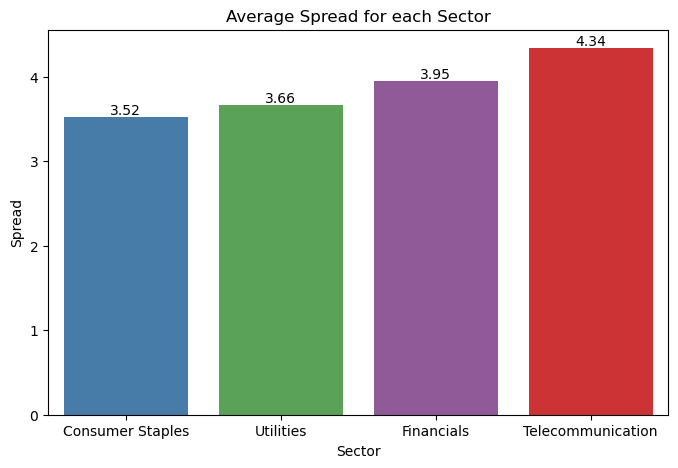

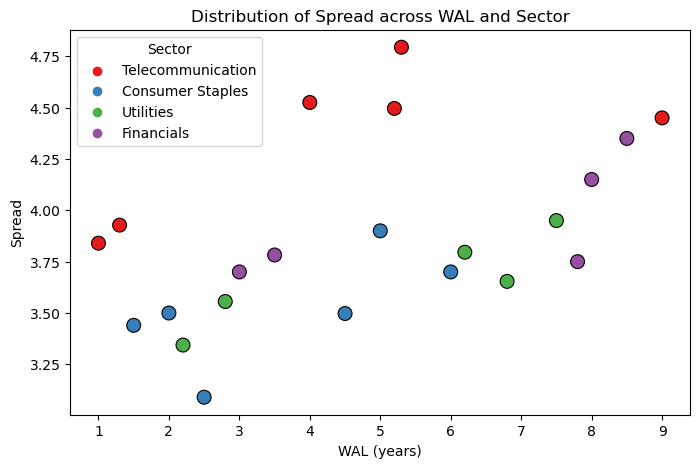

In [101]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_fred_yield(series_id, start_date="2023-01-01", end_date="2023-12-31", api_key=FRED_API_KEY):
    # Define the API URL and parameters here
    fred_url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date,
    }
    # Make an API request and handle errors
    try:
        response = requests.get(fred_url, params)
    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None
    
    # Convert response JSON into a DataFrame, setting 'date' as index
    data = response.json()
    df = pd.DataFrame(data["observations"])
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index('date')

    # Convert the 'value' column to numeric and rename it based on series_id
    df["value"] = pd.to_numeric(df["value"], errors='coerce')
    df = df.rename(columns={'value':series_id})

    return df[[series_id]]  # Final DataFrame with date index and yield column

# List of Treasury yield series IDs on FRED
tenor_series_ids = [
    "DGS1MO", "DGS3MO", "DGS6MO", "DGS1",  # Short-term yields
    "DGS2", "DGS3", "DGS5",               # Medium-term yields
    "DGS7", "DGS10", "DGS20", "DGS30"     # Long-term yields
]

# Initialize API key
FRED_API_KEY = "6f6415b532ae2a8b52143162554206a5"

# Fetch data for each tenor, store in a dictionary of DataFrames
data_dict = {}
for series_id in tenor_series_ids:
    data_dict[series_id] = fetch_fred_yield(series_id)
    
# Combine all DataFrames into a single DataFrame, joining on the date index
treasury_curves = pd.concat(data_dict.values(), axis=1).dropna(how='all')

# Print the number of rows in the final DataFrame
print('Number of rows in the final DataFrame:', len(data))

def interpolate_treasury_yield(bond_maturity, treasury_curve):
    """
    Perform linear interpolation to estimate the Treasury yield for a given bond maturity.
    
    :param bond_maturity: Maturity of the bond (in years)
    :param treasury_curve: Dictionary {maturity (years): yield (decimal)}
    :return: Interpolated Treasury yield (decimal)
    """
    # Extract sorted maturities and corresponding yields
    maturities = np.array(sorted(treasury_curve.keys()))
    yields = np.array([treasury_curve[m] for m in maturities])

    # If exact maturity exists, return the yield directly
    if bond_maturity in treasury_curve:
        return treasury_curve[bond_maturity]
    
    # Find the two nearest maturities
    lower_maturity = maturities[maturities < bond_maturity].max(initial=None)
    upper_maturity = maturities[maturities > bond_maturity].min(initial=None)
    
    # If bond maturity is out of range, return the nearest available yield
    if lower_maturity is None:
        return treasury_curve[upper_maturity]
    if upper_maturity is None:
        return treasury_curve[lower_maturity]

    # Linear interpolation formula
    lower_yield = treasury_curve[lower_maturity]
    upper_yield = treasury_curve[upper_maturity]
    interpolated_yield = lower_yield + (upper_yield - lower_yield) * \
                         ((bond_maturity - lower_maturity) / (upper_maturity - lower_maturity))
    
    return interpolated_yield

bond_yields = pd.read_excel('Part 1. bonds_yields.xlsx')

cur_t_curve = treasury_curves.iloc[-1].to_dict()
cur_t_curve = dict(zip([1/12, 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30], cur_t_curve.values()))

bond_yields['Treasury Yield (Interpolated)'] = [interpolate_treasury_yield(mat, cur_t_curve) for mat in bond_yields['WAL (years)']]
bond_yields['Spread'] = bond_yields['Yield (%)'] - bond_yields['Treasury Yield (Interpolated)']

palette = sns.color_palette("Set1", n_colors=bond_yields["Sector"].nunique())
category_colors = {category: color for category, color in zip(bond_yields["Sector"].unique(), palette)}

# Create grouped bar chart
plt.figure(figsize=(8, 5))
avg_bond_yields = bond_yields.groupby('Sector').mean().reset_index().sort_values('Spread')
ax = sns.barplot(data=avg_bond_yields, x='Sector', y='Spread', palette=category_colors)

# Labels and title
plt.xlabel('Sector')
plt.ylabel('Spread')
plt.title("Average Spread for each Sector")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points", 
                ha='center', va='center')
plt.show()

x_name = 'WAL (years)'
y_name = 'Spread'
z_name = 'Sector'
# Create scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=bond_yields, x=x_name, y=y_name, hue=z_name, palette=category_colors, s=100, edgecolor="black")

# Labels and title
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.title("Distribution of Spread across WAL and Sector")

# Show legend
plt.legend(title=z_name)

# Show plot
plt.show()